In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import ntpath

In [2]:
#!pip install imgaug
#!pip install tensorflow

# 1- load data

In [3]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv (r'driving_log.csv', names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


# 2- split image name only from there path

In [4]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


# 3- plot the stearing angle distripuation

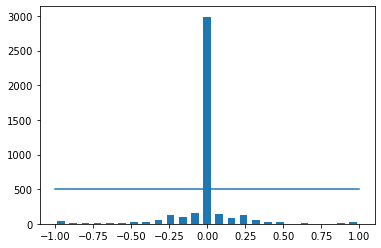

In [5]:
num_bins = 25
sample_ber_bin = 500
hist, bins = np.histogram(data["steering"], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (sample_ber_bin, sample_ber_bin))
plt.show()
#print(bins)

# 3- remove unneeded data 

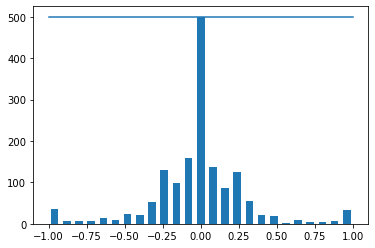

In [6]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and  data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[sample_ber_bin:]
    remove_list.extend(list_)

data.drop(data.index[remove_list], inplace= True)
hist, bins = np.histogram(data["steering"], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (sample_ber_bin, sample_ber_bin))
plt.show()

# 4- merge the 3 pathes coulmn into one coulmn

#### each stearing angle has the images (left, right, center)
#### we have three vectors for imges and one vector for stearing angle

In [7]:
dataDir = r"..\track-master\IMG"
def load_img_(dataDir, df):
    image_path = []
    steering = []
    for center, left, right, ang in zip(df['center'], df['left'], df['right'], df['steering']):
        image_path.append(os.path.join(dataDir, center.strip()))
        steering.append(ang)
        
        image_path.append(os.path.join(dataDir, left.strip()))
        steering.append(ang)
        
        image_path.append(os.path.join(dataDir, right.strip()))
        steering.append(ang)
        
    image_path = np.asarray(image_path)
    steering = np.asarray(steering)
    return image_path, steering

image_pathes, steering = load_img_(dataDir, data)


# 5- train test split

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(image_pathes, steering, test_size= 0.25, random_state= 0)

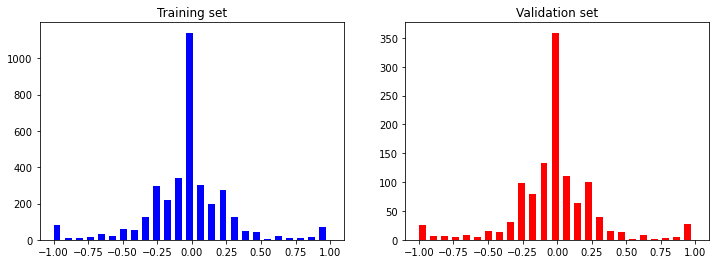

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(y_train, bins= num_bins, width= 0.05, color = 'blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins= num_bins, width= 0.05, color = 'red')
axes[1].set_title('Validation set')
plt.show()

# 6- data agumentaion methods

In [10]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

In [11]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

In [12]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

In [13]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

In [14]:
def random_augment(image, steering_angle):
    #try:
    image = mpimg.imread(image)
    #except:
        #image = 'IMG\center_2018_07_16_17_11_44_209.jpg'
        #steering_angle = 0.02400588
        #image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
        
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
        
    return image, steering_angle

In [15]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

# 7- create the image generator method

In [16]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = np.random.randint(0, len(image_paths) - 1)

        if istraining:
            im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

        else:
            im = mpimg.imread(image_paths[random_index])
            steering = steering_ang[random_index]

        im = img_preprocess(im)
        batch_img.append(im)
        batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))


# 8- define the model architecture

In [17]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24,( 5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='relu'))
    model.add(Convolution2D(36, ( 5, 5), strides=(2, 2), activation='relu'))
    model.add(Convolution2D(48, ( 5, 5), strides=(2, 2), activation='relu'))
    model.add(Convolution2D(64,( 3, 3), activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
#   model.add(Dropout(0.5))


    model.add(Flatten())

    model.add(Dense(100, activation = 'tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation = 'tanh'))
    model.add(Dropout(0.3))

    model.add(Dense(10, activation = 'elu'))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation = 'elu'))
#   model.add(Dropout(0.5))

    model.add(Dense(1))

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer, metrics=[['accuracy', 'mse']], )
    return model

# 9- fit the data

In [19]:
model = nvidia_model()
print(model.summary())
history = model.fit(batch_generator(x_train, y_train, 1500, 1),
                                  steps_per_epoch=1500,
                                  epochs=20,
                                  validation_data=batch_generator(x_valid, y_valid, 750, 0),
                                  validation_steps=445,
                                  verbose=1,
                                  shuffle = 1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 6, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_5 (Dense)             (None, 100)              

# 10- plot accurcy and loss

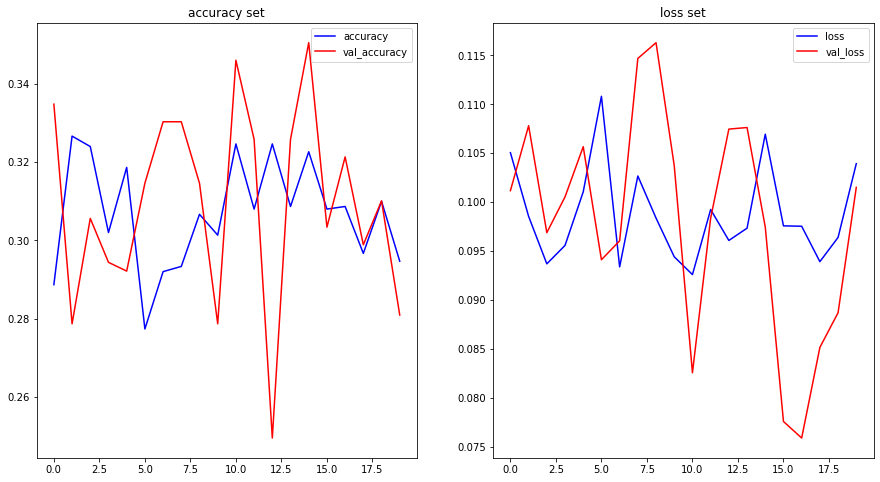

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (15, 8))
axes[0].plot(history.history['accuracy'], color = 'blue')
axes[0].plot(history.history['val_accuracy'], color = 'red')
axes[0].legend(['accuracy', 'val_accuracy'])
axes[0].set_title('accuracy set')

axes[1].plot(loss, color = 'blue')
axes[1].plot(val_loss, color = 'red')
axes[1].legend(['loss', 'val_loss'])
axes[1].set_title('loss set')
plt.show()
